# Analyze network consequences of protein abundance changes - G6PD
Currently set up for a single model
## Setup
### Import packages

In [1]:
from pathlib import Path
from operator import attrgetter
from warnings import warn
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from cobra.flux_analysis import find_blocked_reactions
from cobra.flux_analysis.variability import flux_variability_analysis
from rbc_gem_utils import (
    get_dirpath,
    COBRA_CONFIGURATION,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    ProteinDilution,
    ComplexDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()

Set parameter Username
Set parameter LicenseID to value 2664191

Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.2
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.3
openpyxl                              3.1.5
pandas                                2.2.3
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.3
scikit-learn                          1.6.1
scipy                                1.15.3
seaborn                              0.13.2

Build Tools Information
-----------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues due to protein constraint bounds
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [3]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRedOmics"

### Set computation options

In [4]:
protein_of_interest = "G6PD"


protein_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.dilution"]
protein_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.metabolite"]
relax_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.relaxation"]

budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]

### Set figure options

In [5]:
save_figures = True
transparent = False
imagetype = "svg"

## Load RBC-GEM model

In [6]:
valid_organisms = {"Human", "Mouse"}
if organism not in valid_organisms:
    raise ValueError(f"Organism must be one of the following: {valid_organisms}")

# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id

results_dirpath = get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name

fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "sample_pcmodels"
abundance_change_results_path = results_dirpath / "abundance_changes"

# Ensure directories exist
abundance_change_results_path.mkdir(exist_ok=True, parents=True)

model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=sample_pcmodels_dirpath / f"{model_id}_PC_{dataset_name}.xml")
pcmodel

Name,RBC_GEM_PC_DeepRedOmics
Memory address,26f01d90250
Number of metabolites,10411
Number of reactions,19620
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set protein of interest

In [7]:
protein_gene = pcmodel.genes.get_by_id(protein_of_interest)
protein_met = pcmodel.metabolites.get_by_id(f"{protein_met_prefix}{protein_of_interest}_pc")
protein_rxn = pcmodel.reactions.get_by_id(f"{protein_rxn_prefix}{protein_met.id}")

# Store IDs for later use
protein_mid = protein_met.id
protein_rid = protein_rxn.id
protein_relax_id = f"{relax_rxn_prefix}{protein_mid}"

biochemical_reactions = []
for reaction in sorted(protein_gene.reactions, key=attrgetter("id")):
    if reaction in model.reactions:
        print(model.reactions.get_by_id(reaction.id))
        biochemical_reactions += [reaction.id]
protein_gene

G6PDH2: g6p_c + nadp_c --> 6pgl_c + h_c + nadph_c


Gene identifier,G6PD
Name,G6PD
Memory address,0x26f044242d0
Functional,True
In 8 reaction(s),"G6PDH2, ENZFM_enzyme_G6PDH2_fwd_cplx_HOMOTETRAMER_G6PD_pc, PROTDL_protein_G6PD_pc, ENZDL_enzyme_G6PDH2_fwd_pc, CPLXDL_cplx_HOMOTETRAMER_G6PD_pc, ENZDL_enzyme_G6PDH2_total_pc,..."


### Get original values from model

In [8]:
budget_met_relax = pcmodel.metabolites.get_by_id(f"{budget_met_prefix}relaxation")
budget_rxn_relax = pcmodel.reactions.get_by_id(f"{budget_rxn_prefix}{budget_met_relax}")

orig_relax_budget = budget_rxn_relax.bounds
orig_protein_bounds = protein_rxn.bounds

### Minimize relaxation budget

In [9]:
print("Old relaxation bounds: ({:.6f}, {:.6f})".format(*orig_relax_budget))
# update_slack_value(pcmodel, 0.0012, verbose=True)

relaxdl_reaction = pcmodel.reactions.get_by_id(f"{relax_rxn_prefix}{protein_met_prefix}{protein_of_interest}_pc")
relaxdl_reaction.bounds = (0, 0)

budget_rxn_relax.upper_bound = budget_rxn_relax.lower_bound
print("New relaxation bounds: ({:.6f}, {:.6f})".format(*budget_rxn_relax.bounds))

Old relaxation bounds: (0.001928, 5.041332)
New relaxation bounds: (0.001928, 0.001928)


### Ensure model can optimize all reactions catalyzed by protein of interest

In [10]:
objective_reactions = ["NaKt"] + biochemical_reactions
pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
sol = pcmodel.optimize(raise_error=True)

# Display solution for objective fluxes
objective_sol = sol.fluxes.loc[objective_reactions]
print(f"Optimization objective: {sol.objective_value:.6f}\n{objective_sol}")
# Protein utilized
protein_sol = sol.fluxes.loc[[protein_rid, protein_relax_id]]
print(f"\nProtein utilized: {protein_sol.sum():.6f}\n{protein_sol}")
# Required relaxation budget
relax_sol = sol.fluxes.loc[pcmodel.reactions.query(lambda x: x.id.startswith("RELAX_") or x.id.endswith(budget_met_relax.id)).list_attr("id")]
relax_sol = relax_sol[relax_sol != 0]
relax_budget_used = relax_sol.loc[budget_rxn_relax.id]
print(f"\nTotal relaxation budget utilized: {relax_budget_used:.6f} ({relax_budget_used / budget_rxn_relax.upper_bound:.4%})\n{relax_sol}")

Optimization objective: 0.044057
NaKt      0.024619
G6PDH2    0.019438
Name: fluxes, dtype: float64

Protein utilized: 0.581385
PROTDL_protein_G6PD_pc    0.581385
RELAX_protein_G6PD_pc     0.000000
Name: fluxes, dtype: float64

Total relaxation budget utilized: 0.001928 (100.0000%)
BDL_budget_relaxation      0.001928
RELAX_protein_SLC7A5_pc    0.012240
RELAX_protein_TSPO2_pc     0.065577
Name: fluxes, dtype: float64


## Optimal fluxes as a function of reduction in protein abundance

In [11]:
percent_interval = (0, -100)
proteome_rxns_of_interest =  [
    protein_rid,
    protein_relax_id,
]
biochemical_rxns_of_interest = [
    "G6PDH2",
    "PGL", 
    "GND", 
    "RPI", 
    "RPE", 
    "TKT1",
    "TALA", 
    "TKT2", 
]
objective_reactions = ["NaKt"] + biochemical_reactions


solutions = []
with pcmodel:
    protein_reaction = pcmodel.reactions.get_by_id(protein_rid)
    pcmodel.objective = sum([rxn.flux_expression for rxn in pcmodel.reactions.get_by_any(objective_reactions)])
    
    
    for percent in np.linspace(*percent_interval, 1 + (percent_interval[0] - percent_interval[1])):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent/100),
            orig_protein_bounds[1] * (1 + percent/100),
        )
        sol = pcmodel.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [x for x in objective_reactions if x not in biochemical_rxns_of_interest]
            + [x for x in proteome_rxns_of_interest if x not in objective_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
G6PDH2,0.019438,0.019243,0.019049,0.018854,0.018660,0.018466,0.018271,0.018077,0.017883,0.017688,...,0.001749,0.001555,0.001361,0.001166,0.000972,0.000778,0.000583,0.000389,0.000194,0.000000
PGL,0.019438,0.019243,0.019049,0.018854,0.018660,0.018466,0.018271,0.018077,0.017883,0.017688,...,0.001749,0.001555,0.001361,0.001166,0.000972,0.000778,0.000583,0.000389,0.000194,0.000000
GND,0.019438,0.019243,0.019049,0.018854,0.018660,0.018466,0.018271,0.018077,0.017883,0.017688,...,0.001749,0.001555,0.001361,0.001166,0.000972,0.000778,0.000583,0.000389,0.000194,0.000000
RPI,0.004231,0.004192,0.004153,0.004114,0.004075,0.004037,0.003998,0.003959,0.003920,0.003881,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RPE,0.015207,0.015051,0.014896,0.014740,0.014585,0.014429,0.014274,0.014118,0.013963,0.013807,...,0.001749,0.001555,0.001361,0.001166,0.000972,0.000778,0.000583,0.000389,0.000194,0.000000
TKT1,0.007603,0.007526,0.007448,0.007370,0.007292,0.007215,0.007137,0.007059,0.006981,0.006904,...,0.000875,0.000778,0.000680,0.000583,0.000486,0.000389,0.000292,0.000194,0.000097,0.000000
TALA,0.007603,0.007526,0.007448,0.007370,0.007292,0.007215,0.007137,0.007059,0.006981,0.006904,...,0.000875,0.000778,0.000680,0.000583,0.000486,0.000389,0.000292,0.000194,0.000097,0.000000
TKT2,0.007603,0.007526,0.007448,0.007370,0.007292,0.007215,0.007137,0.007059,0.006981,0.006904,...,0.000875,0.000778,0.000680,0.000583,0.000486,0.000389,0.000292,0.000194,0.000097,0.000000
NaKt,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,...,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619,0.024619
PROTDL_protein_G6PD_pc,0.581385,0.575571,0.569757,0.563943,0.558129,0.552316,0.546502,0.540688,0.534874,0.529060,...,0.052325,0.046511,0.040697,0.034883,0.029069,0.023255,0.017442,0.011628,0.005814,0.000000


### Plot results for flux as a function of protein abundance

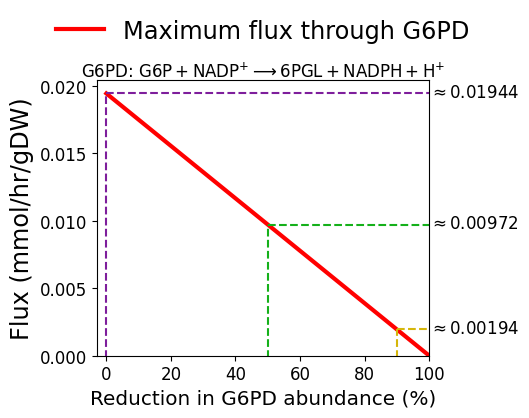

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
G6PDH2_flux = df_solutions.loc[["G6PDH2"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
G6PDH2_flux.index *= -1
G6PDH2_flux.plot(
    ax=ax, 
    color="red", 
    linewidth=3, 
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    f"{protein_of_interest}: " + "$\\text{G6P} + \\text{NADP}^{+} \\longrightarrow \\text{6PGL} + \\text{NADPH} + \\text{H}^{+}$", 
    xy=(0.5, 1.03),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="large"
)


xpad = 3
ypad = 0.001
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(G6PDH2_flux.min(), G6PDH2_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)",fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large")


# Add annotations for 50% (1 allele copy) and 90% (2 allele copies)
pad = 0.00025
for pct, ls, color in zip(
    [0, 50, 90], 
    ["--", "--", "--"], 
    ["xkcd:purple", "xkcd:green", "xkcd:dark yellow"]
):
    ymax = G6PDH2_flux.loc[pct]
    ax.vlines(
        x=pct,
        ymin=G6PDH2_flux.min() - ypad,
        ymax=ymax,
        linestyle=ls,
        color=color,
        linewidth=1.5
    )
    ax.hlines(
        y=ymax,
        xmin=pct,
        xmax=100,
        linestyle=ls,
        color=color,
        linewidth=1.5
    )
    ax.annotate(
        approx_label_fmt.format(ymax), 
        xy=(100, ymax - pad), 
        xycoords="data",
        fontsize="large"
    )

ftype = "svg"
fig.tight_layout()
if save_figures:
    fig.savefig(
        abundance_change_results_path 
        / f"Reduction_{protein_of_interest}_Panel.{ftype}", 
        transparent=transparent, 
        format=ftype
    )